In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

In [83]:
# Start and connect to a local H2O cluster
import h2o
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,1 hour 9 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.5
H2O cluster version age:,"14 days, 12 hours and 55 minutes"
H2O cluster name:,H2O_from_python_gaozhiping_m9096x
H2O cluster total nodes:,1
H2O cluster free memory:,1.676 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [102]:
# Import wine quality data from a local CSV file
wine = h2o.import_file("winequality-white.csv")
wine.head(5)

Parse progress: |█████████████████████████████████████████████████████████| 100%


fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6
6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6
8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6


In [103]:
# Define features (or predictors)
features = list(wine.columns) # we want to use all the information
features.remove('quality')    # we need to exclude the target 'quality' (otherwise there is nothing to predict)
features

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [104]:
# Split the H2O data frame into training/test sets
# so we can evaluate out-of-bag performance
wine_split = wine.split_frame(ratios = [0.8], seed = 1234)

wine_train = wine_split[0] # using 80% for training
wine_test = wine_split[1]  # using the rest 20% for out-of-bag evaluation

In [105]:
wine_train.shape

(3932, 12)

In [106]:
wine_test.shape

(966, 12)

## Step 1 - Gradient Boosting Machines (GBM) with Default Settings

In [107]:
# Build a Gradient Boosting Machines (GBM) model with default settings

# Import the function for GBM
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# Set up GBM for regression
# Add a seed for reproducibility
gbm_default = H2OGradientBoostingEstimator(model_id = 'gbm_default', 
                                           seed = 1234)

# Use .train() to build the model
gbm_default.train(x = features, 
                  y = 'quality', 
                  training_frame = wine_train)

# Check the model performance on test dataset
gbm_default.model_performance(wine_test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.4569904494269438
RMSE: 0.6760106873614823
MAE: 0.5248612169030329
RMSLE: 0.10032043310648843
Mean Residual Deviance: 0.4569904494269438


In [51]:
train_Set = wine_train.as_data_frame()
test_Set = wine_test.as_data_frame()
y_train = train_Set.quality
X_train = train_Set.drop('quality', axis=1)
y_test = test_Set.quality
X_test = test_Set.drop('quality', axis=1)

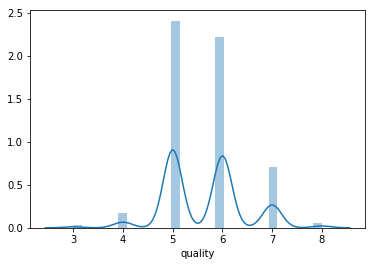

In [52]:
sns.distplot(y_train)

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [54]:
compare_dic = {}
# Linear Regression
reg1 = LinearRegression()
# Lasso model
parameters = {"alpha" : [i/80 for i in range(0,80,5)]}
reg2 = linear_model.Lasso()
Lasso = GridSearchCV(reg2, parameters, cv = 5, scoring="neg_mean_squared_error")
# Ridge Regression
parameters = {"alpha" : [i/80 for i in range(0,80,5)]}
reg3 = Ridge()
Ridge = GridSearchCV(reg3, parameters, cv = 5, scoring="neg_mean_squared_error")
#Elastic Net
parameters = {"alpha" : [i/80 for i in range(0,80,5)], "l1_ratio":[i/80 for i in range(0,80,5)]}
reg4 = ElasticNet(random_state=0)
Ela = GridSearchCV(reg4, parameters, cv = 5, scoring="neg_mean_squared_error")
#Desition Tree
parameters = {"max_depth" : [2,4,5,7,8,10]}
dt   = DecisionTreeRegressor()
model_dt = GridSearchCV(dt, parameters, cv = 5, scoring="neg_mean_squared_error")
#Random Forest
parameters = {"n_estimators" : [50,90,100,120, 140, 160], "max_depth" : [7,8,10, 12, 14]}
rf   = RandomForestRegressor(random_state=0)
model_RF = GridSearchCV(rf, parameters, cv = 5, scoring="neg_mean_squared_error")

model_list = [reg1, Lasso, Ridge, Ela, model_dt, model_RF]
model_name = ["Linear Regression", "Lasso Regression", "Ridge Regression", "Elastic Net", "Decision Tree", "Random Forest"]
for i in range(len(model_list)):
    model = model_list[i]
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    compare_dic[model_name[i]] = mean_squared_error(y_test, pred, )
    print(metrics.mean_squared_error(y_test, pred))

0.47471939873160035
0.47471939873159996
0.4742614160267522
0.47471939873159996
0.5016985206052926
0.41597293148712183


In [55]:
model_RF.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [74]:
# Gradient Boost
from sklearn.ensemble import GradientBoostingRegressor
import time
parameters = {'max_depth': [3, 5, 7],
             'subsample': [0.7, 0.8, 0.9],
             'max_features':[0.7, 0.8, 0.9]}
gbr   = GradientBoostingRegressor(n_estimators = 10000)
model_gbr = GridSearchCV(gbr, parameters, cv = 5, scoring="neg_mean_squared_error")

start_time = time.time()
model_gbr.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))

pred = model_gbr.predict(X_test)
print(metrics.mean_squared_error(y_test, pred))

--- 615.7437300682068 seconds ---
0.3913456998235284


## GBM with CV, Early Stopping and Random Grid Search

In [90]:
from h2o.grid.grid_search import H2OGridSearch

In [91]:
# define the criteria for random grid search
search_criteria = {'strategy': "RandomDiscrete", 
                   'max_models': 9,
                   'seed': 1234}

In [92]:
# define the range of hyper-parameters for grid search
# 27 combinations in total
hyper_params = {'sample_rate': [0.7, 0.8, 0.9],
                'col_sample_rate': [0.7, 0.8, 0.9],
                'max_depth': [3, 5, 7]}

In [93]:
# Set up GBM grid search
# Add a seed for reproducibility
gbm_rand_grid = H2OGridSearch(
                    H2OGradientBoostingEstimator(
                        model_id = 'gbm_rand_grid', 
                        seed = 1234,
                        ntrees = 10000,   
                        nfolds = 5,
                        stopping_metric = 'mse', 
                        stopping_rounds = 15,     
                        score_tree_interval = 1),
                    search_criteria = search_criteria, # full grid search
                    hyper_params = hyper_params)

In [94]:
# Use .train() to start the grid search
start_time = time.time()
gbm_rand_grid.train(x = features, 
                    y = 'quality', 
                    training_frame = wine_train)
print("--- %s seconds ---" % (time.time() - start_time))

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
--- 12.33520221710205 seconds ---


In [96]:
# Sort and show the grid search results
gbm_rand_grid_sorted = gbm_rand_grid.get_grid(sort_by='mse', decreasing=False)
print(gbm_rand_grid_sorted)

    col_sample_rate max_depth sample_rate  \
0               0.9         7         0.9   
1               0.8         7         0.7   
2               0.7         7         0.7   
3               0.9         7         0.7   
4               0.7         5         0.8   
5               0.8         3         0.8   
6               0.9         3         0.9   
7               0.8         3         0.9   
8               0.7         3         0.7   

                                                         model_ids  \
0  Grid_GBM_py_14_sid_985f_model_python_1562179094070_6748_model_6   
1  Grid_GBM_py_14_sid_985f_model_python_1562179094070_6748_model_5   
2  Grid_GBM_py_14_sid_985f_model_python_1562179094070_6748_model_2   
3  Grid_GBM_py_14_sid_985f_model_python_1562179094070_6748_model_7   
4  Grid_GBM_py_14_sid_985f_model_python_1562179094070_6748_model_1   
5  Grid_GBM_py_14_sid_985f_model_python_1562179094070_6748_model_4   
6  Grid_GBM_py_14_sid_985f_model_python_1562179094070_6748_

In [97]:
# Extract the best model from random grid search
best_model_id = gbm_rand_grid_sorted.model_ids[0]
best_gbm_from_rand_grid = h2o.get_model(best_model_id)
best_gbm_from_rand_grid.summary()

Model Summary: 


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,76.0,76.0,35556.0,7.0,7.0,7.0,9.0,59.0,32.539474


In [98]:
# Check the model performance on test dataset
best_gbm_from_rand_grid.model_performance(wine_test)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.3930776556036911
RMSE: 0.6269590541683653
MAE: 0.4694048890596397
RMSLE: 0.09936814298686422
Mean Residual Deviance: 0.3930776556036911


In [99]:
prediction = best_gbm_from_rand_grid.predict(wine_test).as_data_frame()
prediction.columns = ["h2o"]
prediction['sklearn'] = model_gbr.predict(X_test)
prediction["true"] = y_test
prediction["h2o_residual"] = prediction.h2o - prediction.true
prediction["sklearn_residual"] = prediction.sklearn - prediction.true

gbm prediction progress: |████████████████████████████████████████████████| 100%


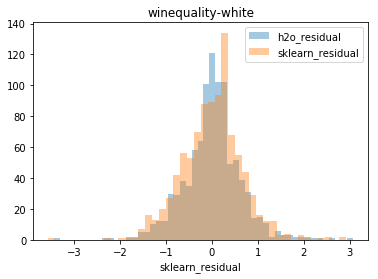

In [58]:
sns.distplot(prediction.h2o_residual,label='h2o_residual', kde=False)
sns.distplot(prediction.sklearn_residual, label='sklearn_residual', kde=False)
plt.title("winequality-white")
plt.legend()
plt.show()

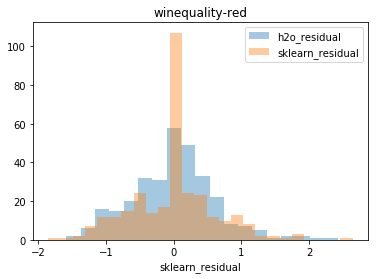

In [101]:
sns.distplot(prediction.h2o_residual,label='h2o_residual', kde=False)
sns.distplot(prediction.sklearn_residual, label='sklearn_residual', kde=False)
plt.title("winequality-red")
plt.legend()
plt.show()